Loading embeddings from: ./embeddings/final_embeddings_molecules_20250309_110249.pkl
Loaded 9937 embeddings
Reducing dimensionality with UMAP...


C:\Users\Malli\anaconda3\envs\baceenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malli\anaconda3\envs\baceenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Rebuilding molecules from graph data...
Successfully rebuilt 9937 molecules
Calculating molecular properties...
Creating composite property score...
Clustering embeddings...
Finding representative molecules for each cluster...
Creating composite property visualization...
Visualization saved to: ./visualization_files\composite_property_embedding.png
Saving cluster information...
Saved cluster information to ./visualization_files\cluster_info.json
Visualization complete! Now run the molecule rendering script.


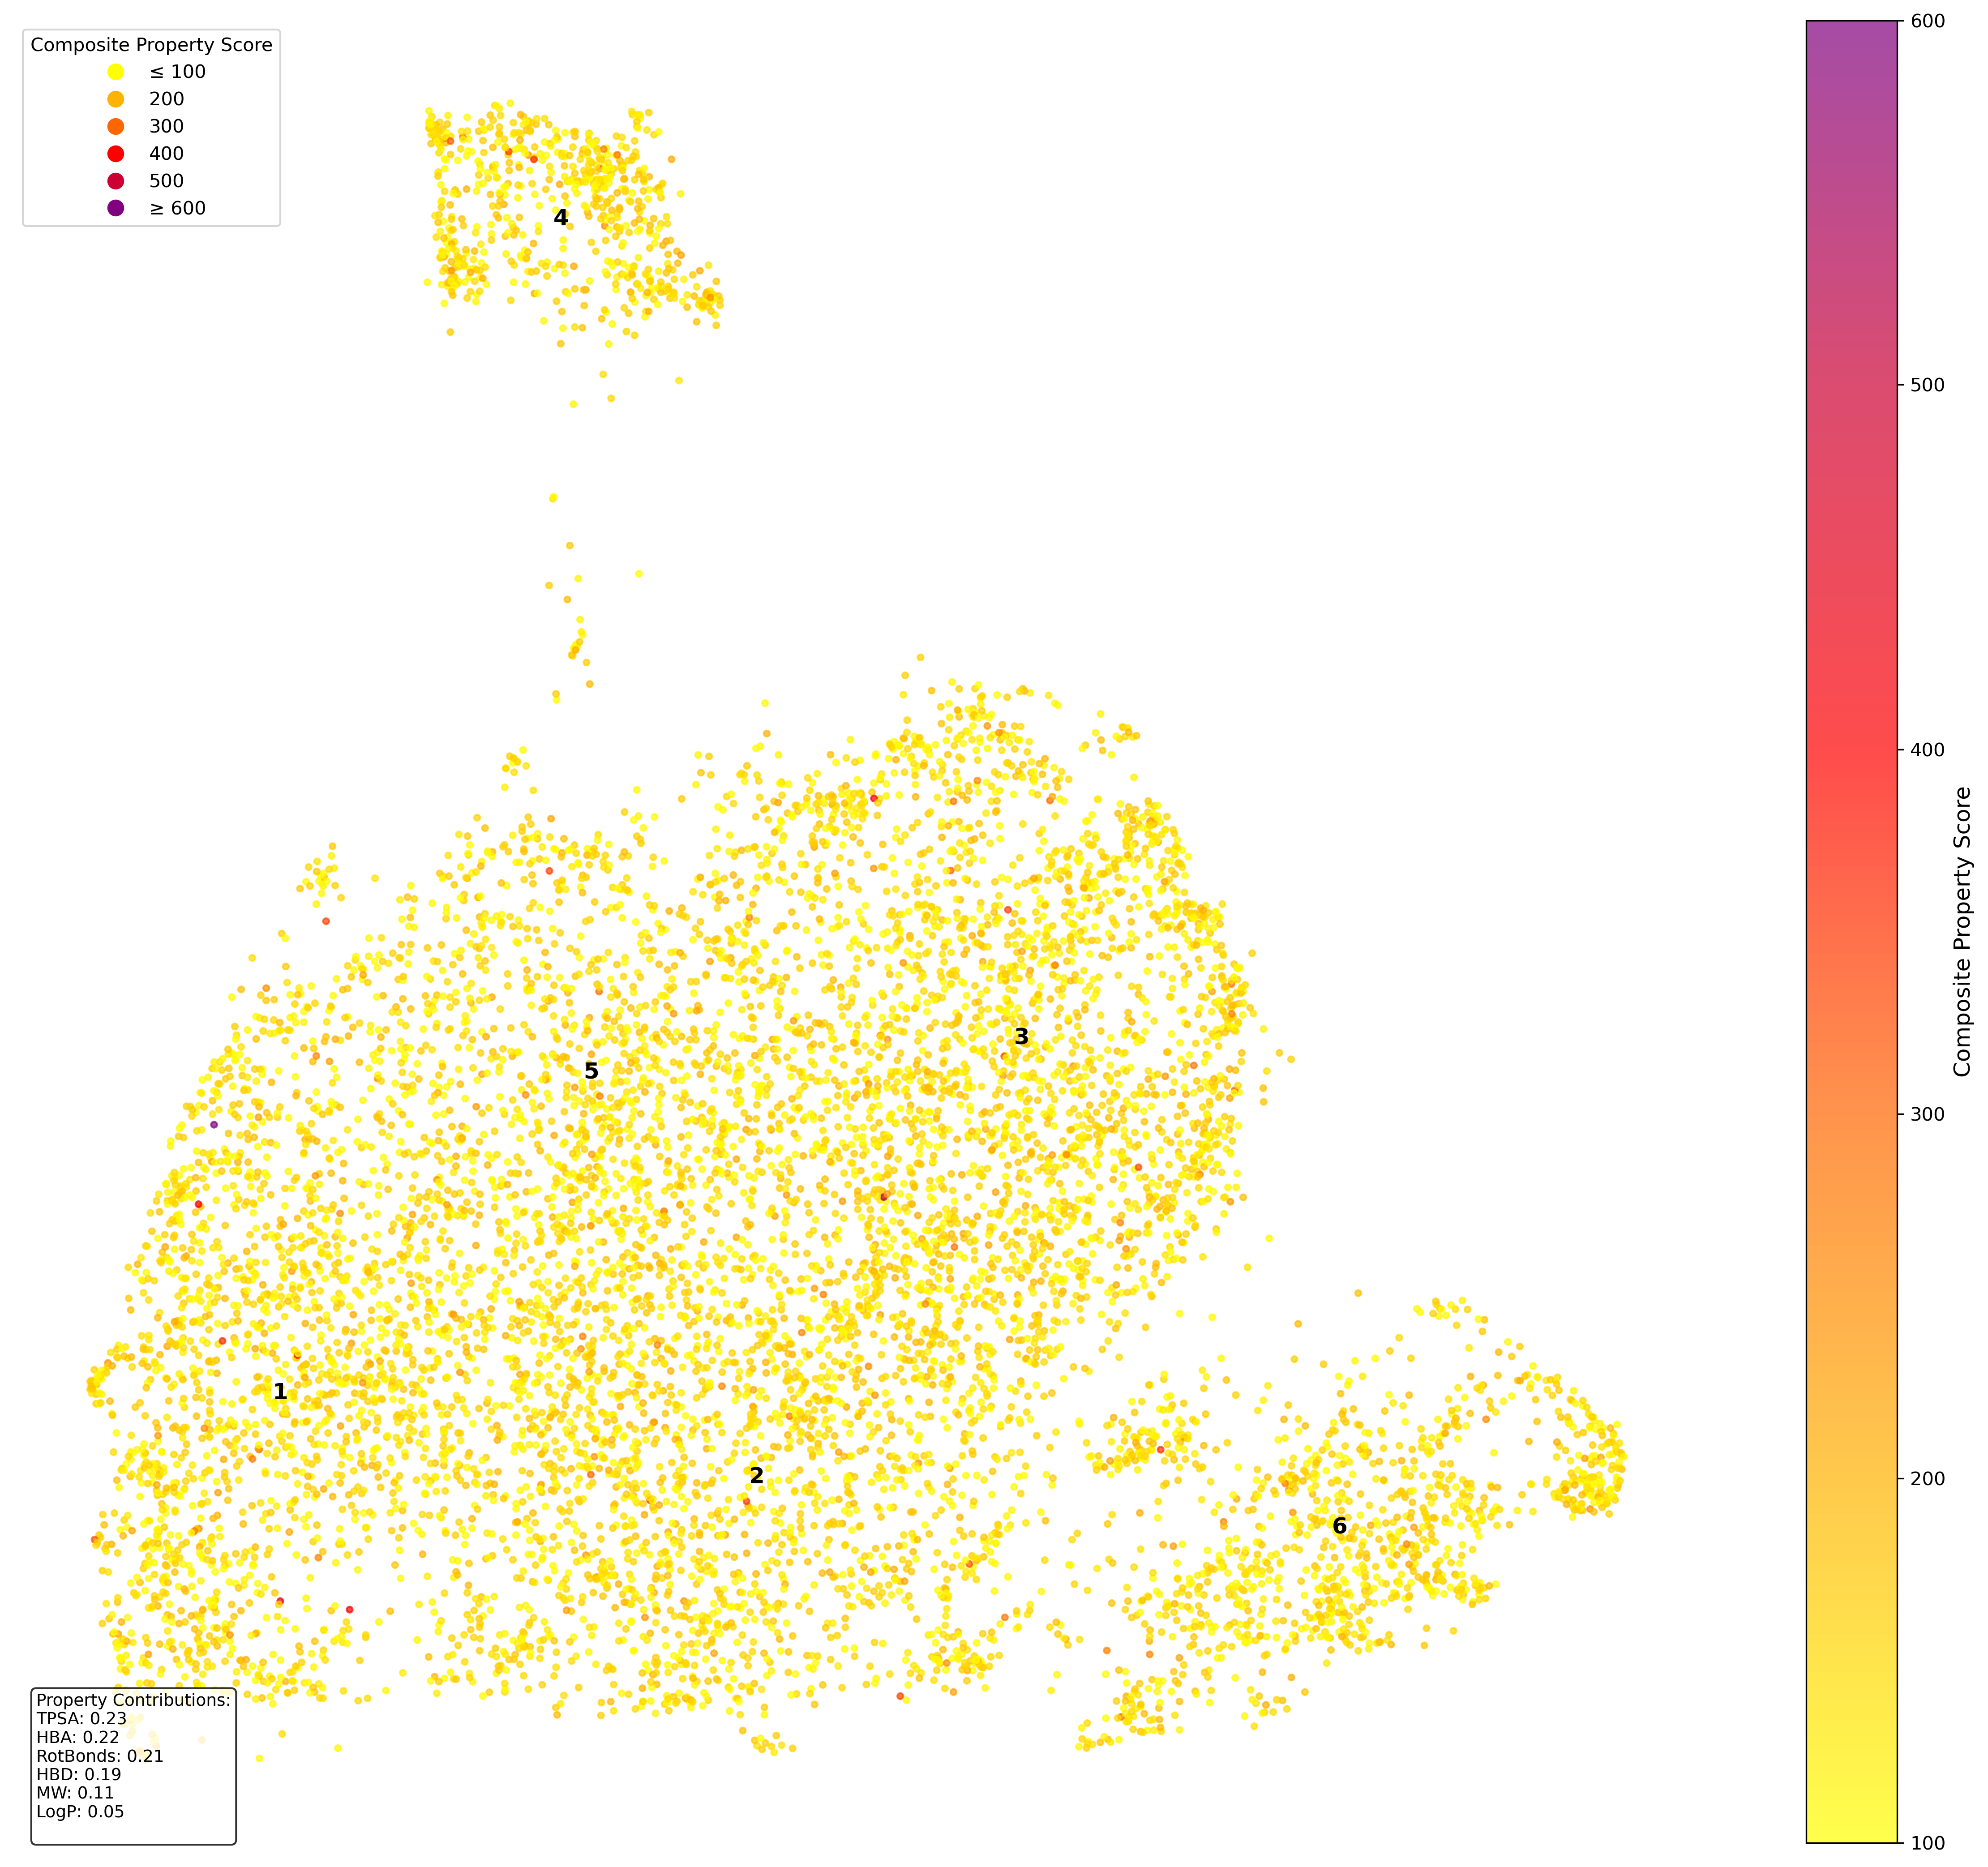

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import os
import json
from matplotlib.lines import Line2D
from rdkit import RDLogger

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

def load_embeddings(filepath):
    """Load embeddings and molecule data from file"""
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    
    embeddings = data['embeddings']
    molecule_data = data.get('molecule_data', None)
    
    return embeddings, molecule_data

def reduce_dimensions(embeddings, method='umap', n_components=2, **kwargs):
    """Reduce dimensionality of embeddings for visualization"""
    if method.lower() == 'tsne':
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=n_components, random_state=42, **kwargs)
    elif method.lower() == 'umap':
        import umap
        reducer = umap.UMAP(n_components=n_components, random_state=42, **kwargs)
    elif method.lower() == 'pca':
        from sklearn.decomposition import PCA
        reducer = PCA(n_components=n_components, **kwargs)
    else:
        raise ValueError(f"Unknown dimensionality reduction method: {method}")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

def rebuild_molecules_from_graph_data(molecule_data_list):
    """Reconstruct RDKit molecules from graph data - simplified version"""
    # Maps for atom and bond features
    atom_list = list(range(1, 119))
    bond_list = [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE, 
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC
    ]
    
    molecules = []
    valid_count = 0
    
    for mol_data in molecule_data_list:
        try:
            # Create empty editable molecule
            mol = Chem.RWMol()
            
            # Add atoms based on x_cat data
            x_cat = mol_data.get('x_cat')
            if x_cat is None:
                molecules.append(None)
                continue
                
            for atom_features in x_cat:
                atomic_num = atom_list[atom_features[0]]
                atom = Chem.Atom(atomic_num)
                mol.AddAtom(atom)
            
            # Add bonds based on edge_index and edge_attr
            edge_index = mol_data.get('edge_index')
            edge_attr = mol_data.get('edge_attr')
            
            if edge_index is None or edge_attr is None:
                molecules.append(None)
                continue
                
            # Process only in one direction (undirected edges appear twice)
            processed_edges = set()
            
            for i in range(len(edge_index[0])):
                start, end = edge_index[0][i], edge_index[1][i]
                if start >= mol.GetNumAtoms() or end >= mol.GetNumAtoms():
                    continue
                if (start, end) in processed_edges or (end, start) in processed_edges:
                    continue
                    
                # Add the bond
                try:
                    bond_type_idx = int(edge_attr[i][0])
                    if bond_type_idx < len(bond_list):
                        bond_type = bond_list[bond_type_idx]
                        mol.AddBond(start, end, bond_type)
                        processed_edges.add((start, end))
                except Exception:
                    continue
            
            # Convert to molecule
            try:
                final_mol = Chem.Mol(mol)
                for atom in final_mol.GetAtoms():
                    atom.UpdatePropertyCache(strict=False)
                
                # Try to sanitize with error catching
                try:
                    Chem.SanitizeMol(final_mol)
                except:
                    pass
                    
                molecules.append(final_mol)
                valid_count += 1
            except Exception:
                molecules.append(None)
                
        except Exception:
            molecules.append(None)
    
    print(f"Successfully rebuilt {valid_count} molecules")
    return molecules

def calculate_molecule_properties(molecules):
    """Calculate multiple properties for each molecule and combine them"""
    # Initialize property arrays
    n_molecules = len(molecules)
    properties = {
        'MW': np.zeros(n_molecules),
        'LogP': np.zeros(n_molecules),
        'TPSA': np.zeros(n_molecules),
        'HBA': np.zeros(n_molecules),
        'HBD': np.zeros(n_molecules),
        'RotBonds': np.zeros(n_molecules),
        'AromaticRings': np.zeros(n_molecules),
        'HeavyAtoms': np.zeros(n_molecules)
    }
    
    # Calculate properties for each molecule
    for i, mol in enumerate(molecules):
        if mol is None:
            continue
            
        try:
            # Basic properties
            properties['MW'][i] = Descriptors.MolWt(mol)
            properties['LogP'][i] = Descriptors.MolLogP(mol)
            properties['TPSA'][i] = Descriptors.TPSA(mol)
            properties['HBA'][i] = Descriptors.NumHAcceptors(mol)
            properties['HBD'][i] = Descriptors.NumHDonors(mol)
            properties['RotBonds'][i] = Descriptors.NumRotatableBonds(mol)
            properties['AromaticRings'][i] = Chem.Lipinski.NumAromaticRings(mol)
            properties['HeavyAtoms'][i] = Descriptors.HeavyAtomCount(mol)
        except:
            pass
    
    return properties

def create_composite_property_score(properties):
    """Create a composite score from multiple properties"""
    # Extract properties
    mw = properties['MW']
    logp = properties['LogP']
    tpsa = properties['TPSA']
    hba = properties['HBA']
    hbd = properties['HBD']
    rotbonds = properties['RotBonds']
    
    # Create a standardized composite score
    # First create property matrix
    prop_matrix = np.vstack([
        mw,
        logp, 
        tpsa,
        hba,
        hbd,
        rotbonds
    ]).T
    
    # Standardize the properties (mean=0, std=1)
    scaler = StandardScaler()
    std_props = scaler.fit_transform(prop_matrix)
    
    # Compute the first principal component as composite score
    from sklearn.decomposition import PCA
    pca = PCA(n_components=1)
    composite = pca.fit_transform(std_props).flatten()
    
    # Scale to 0-600 range for coloring similar to molecular weight
    min_val = np.min(composite)
    max_val = np.max(composite)
    scaled_composite = 100 + 500 * (composite - min_val) / (max_val - min_val)
    
    # Feature importance for legend
    feature_importance = pca.components_[0]
    normalized_importance = np.abs(feature_importance) / np.sum(np.abs(feature_importance))
    
    feature_names = ['MW', 'LogP', 'TPSA', 'HBA', 'HBD', 'RotBonds']
    importance_dict = {name: float(imp) for name, imp in zip(feature_names, normalized_importance)}
    
    return scaled_composite, importance_dict

def create_property_colormap():
    """Create a custom colormap for molecular properties"""
    # Define the colors from light yellow to dark red/purple
    colors = [
        (1.0, 1.0, 0.0),      # light yellow
        (1.0, 0.7, 0.0),      # gold/amber
        (1.0, 0.4, 0.0),      # orange
        (1.0, 0.0, 0.0),      # red
        (0.8, 0.0, 0.2),      # dark red
        (0.5, 0.0, 0.5)       # purple
    ]
    
    # Create colormap
    cmap = LinearSegmentedColormap.from_list("property_colormap", colors)
    return cmap

def cluster_embeddings(embeddings_2d, n_clusters=6):
    """Cluster embeddings using KMeans"""
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(embeddings_2d)
    
    # Get cluster centers
    centers = kmeans.cluster_centers_
    
    return clusters, centers

def find_cluster_representatives(embeddings_2d, clusters, molecules, n_per_cluster=3):
    """Find representative molecules for each cluster"""
    unique_clusters = np.unique(clusters)
    representatives = {}
    
    for cluster_id in unique_clusters:
        # Get indices of molecules in this cluster
        cluster_indices = np.where(clusters == cluster_id)[0]
        
        # Filter for valid molecules
        valid_indices = [idx for idx in cluster_indices if idx < len(molecules) and molecules[idx] is not None]
        
        if not valid_indices:
            continue
            
        # Get cluster center
        cluster_points = embeddings_2d[cluster_indices]
        center = np.mean(cluster_points, axis=0)
        
        # Find closest molecules to center
        distances = np.sqrt(np.sum((embeddings_2d[valid_indices] - center)**2, axis=1))
        closest_indices = np.argsort(distances)[:n_per_cluster]
        
        # Get the actual indices in the original dataset
        representative_indices = [valid_indices[i] for i in closest_indices]
        
        representatives[cluster_id] = representative_indices
    
    return representatives

def visualize_with_composite_properties(
    embeddings_2d, 
    composite_scores,
    property_importance,
    cluster_centers,
    figsize=(16, 14), 
    dpi=300, 
    save_path=None
):
    """Create an embedding visualization colored by composite property score"""
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi, facecolor='white')
    
    # Create colormap
    cmap = create_property_colormap()
    
    # Plot points
    scatter = ax.scatter(
        embeddings_2d[:, 0], 
        embeddings_2d[:, 1], 
        c=composite_scores,
        cmap=cmap,
        alpha=0.7,
        s=10,
        vmin=100,
        vmax=600
    )
    
    # Add cluster numbers
    for i, (x, y) in enumerate(cluster_centers):
        ax.text(x, y, str(i+1), ha='center', va='center', 
                fontsize=12, fontweight='bold', color='black')
    
    # Create custom legend for composite property
    score_values = [100, 200, 300, 400, 500, 600]
    
    legend_elements = []
    for score in score_values:
        if score == 100:
            label = '≤ 100'
        elif score == 600:
            label = '≥ 600' 
        else:
            label = f'{score}'
            
        color = cmap((score - 100) / 500)
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                   markersize=10, label=label)
        )
    
    # Add legend
    ax.legend(
        handles=legend_elements,
        title='Composite Property Score',
        loc='upper left',
        frameon=True,
        fontsize=10
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Composite Property Score', fontsize=12)
    
    # Add property importance as text
    importance_text = "Property Contributions:\n"
    for prop, importance in sorted(property_importance.items(), key=lambda x: x[1], reverse=True):
        importance_text += f"{prop}: {importance:.2f}\n"
    
    # Place text in bottom left
    plt.figtext(0.02, 0.02, importance_text, fontsize=9, 
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Remove border
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Tight layout
    plt.tight_layout()
    
    # Save figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Visualization saved to: {save_path}")
    
    return fig

def save_cluster_info(
    cluster_representatives, 
    clusters, 
    molecules, 
    embeddings_2d, 
    mol_properties,
    output_path
):
    """Save information about clusters and their representative molecules"""
    # Convert RDKit molecules to SMILES
    smiles_list = []
    for mol in molecules:
        try:
            if mol is not None:
                smiles = Chem.MolToSmiles(mol)
                smiles_list.append(smiles)
            else:
                smiles_list.append(None)
        except:
            smiles_list.append(None)
    
    # Create cluster info
    cluster_info = []
    
    for cluster_id, indices in cluster_representatives.items():
        # Get representative molecules
        representatives = []
        
        for idx in indices:
            if idx < len(molecules) and molecules[idx] is not None:
                try:
                    properties = {
                        'MW': float(mol_properties['MW'][idx]),
                        'LogP': float(mol_properties['LogP'][idx]),
                        'TPSA': float(mol_properties['TPSA'][idx]),
                        'HBA': int(mol_properties['HBA'][idx]),
                        'HBD': int(mol_properties['HBD'][idx])
                    }
                    
                    representatives.append({
                        "index": int(idx),
                        "smiles": smiles_list[idx],
                        "position": embeddings_2d[idx].tolist(),
                        "properties": properties
                    })
                except:
                    pass
        
        # Count molecules in cluster
        cluster_size = np.sum(clusters == cluster_id)
        
        # Add cluster info
        cluster_info.append({
            "cluster_id": int(cluster_id) + 1,  # 1-based IDs for display
            "size": int(cluster_size),
            "representatives": representatives
        })
    
    # Save to JSON
    with open(output_path, 'w') as f:
        json.dump(cluster_info, f, indent=2)
        
    print(f"Saved cluster information to {output_path}")
    
    return cluster_info

def main():
    # Create output directory
    output_dir = './visualization_files'
    os.makedirs(output_dir, exist_ok=True)
    
    # Load embeddings
    embeddings_path = './embeddings/final_embeddings_molecules_20250309_110249.pkl'  
    
    try:
        print(f"Loading embeddings from: {embeddings_path}")
        embeddings, molecule_data = load_embeddings(embeddings_path)
        print(f"Loaded {len(embeddings)} embeddings")
    except Exception as e:
        print(f"Error loading embeddings: {e}")
        print("Please provide a valid embeddings file")
        return
    
    # Reduce dimensionality for visualization
    print("Reducing dimensionality with UMAP...")
    try:
        embeddings_2d = reduce_dimensions(
            embeddings, 
            method='umap',
            n_neighbors=30,
            min_dist=0.1,
            metric='cosine'
        )
    except Exception as e:
        print(f"Error with UMAP: {e}")
        print("Falling back to PCA...")
        embeddings_2d = reduce_dimensions(embeddings, method='pca')
    
    # Rebuild molecules
    print("Rebuilding molecules from graph data...")
    molecules = rebuild_molecules_from_graph_data(molecule_data)
    
    # Calculate multiple molecular properties
    print("Calculating molecular properties...")
    mol_properties = calculate_molecule_properties(molecules)
    
    # Create composite property score
    print("Creating composite property score...")
    composite_scores, property_importance = create_composite_property_score(mol_properties)
    
    # Cluster the embeddings
    print("Clustering embeddings...")
    n_clusters = 6  # As shown in your reference image
    clusters, centers = cluster_embeddings(embeddings_2d, n_clusters=n_clusters)
    
    # Find representative molecules for each cluster
    print("Finding representative molecules for each cluster...")
    cluster_representatives = find_cluster_representatives(
        embeddings_2d, 
        clusters, 
        molecules, 
        n_per_cluster=3
    )
    
    # Create visualization
    print("Creating composite property visualization...")
    fig = visualize_with_composite_properties(
        embeddings_2d,
        composite_scores,
        property_importance,
        centers,
        figsize=(16, 14),
        dpi=300,
        save_path=os.path.join(output_dir, 'composite_property_embedding.png')
    )
    
    # Save cluster information for molecule rendering
    print("Saving cluster information...")
    save_cluster_info(
        cluster_representatives,
        clusters,
        molecules,
        embeddings_2d,
        mol_properties,
        os.path.join(output_dir, 'cluster_info.json')
    )
    
    print("Visualization complete! Now run the molecule rendering script.")

if __name__ == "__main__":
    main()